In [22]:
# --- Install necessary packages ---
!pip install transformers datasets torch scikit-learn fastapi uvicorn streamlit seaborn safetensors
!pip install nlpaug
!pip install nltk
!pip install sacremoses # <-- ADD THIS LINE

The system cannot find the file specified.


In [2]:
# --- Import required libraries ---
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from datasets import Dataset as HFDataset
from torch.utils.data import Dataset
import random

# --- New imports for augmentation ---
import nlpaug.augmenter.word as naw
import nltk
from tqdm.auto import tqdm # To show a progress bar

c:\Users\Sourabh\anaconda3\envs\news_sentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# --- Seed control for reproducibility ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Check available device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if str(device) == "cuda":
    print(f"Detected GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
Detected GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [4]:
# --- Load the VERIFIED dataset and drop NaN values ---
# This assumes your CSV is in the same folder as your notebook
file_path = "news_sentiment_balanced.csv"

try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}")
except FileNotFoundError:
    print(f"Error: Could not find the file '{file_path}'.")
    print("Please make sure it's in the same directory as your notebook.")

df.dropna(subset=["Description", "verified_sentiment"], inplace=True)

Successfully loaded news_sentiment_balanced.csv


In [5]:
# --- Text preprocessing ---
df["cleaned_text"] = df["Description"].astype(str).str.lower()

# --- Sentiment mapping ---
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
df["verified_sentiment"] = df["verified_sentiment"].str.lower().map(sentiment_mapping)
df.dropna(subset=["verified_sentiment"], inplace=True)

# --- Prepare texts and labels ---
labels = df["verified_sentiment"].tolist()
texts = df["cleaned_text"].tolist()

# --- Train/test split ---
# We split the *original* data first to keep the test set clean
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# --- [PHASE 1 - ISOLATE MINORITY SAMPLES] ---
# 1. Put the training data into a temporary DataFrame for easy filtering
train_df = pd.DataFrame({
    'text': train_texts,
    'label': train_labels
})

# 2. Filter for "Positive" (Class 2) samples
positive_samples_df = train_df[train_df['label'] == 2]
positive_texts_to_augment = positive_samples_df['text'].tolist()
print(f"Found {len(positive_texts_to_augment)} 'Positive' (Class 2) samples in the training set to augment.")

# 3. [CORRECTED] Filter for "Negative" (Class 0) samples
negative_samples_df = train_df[train_df['label'] == 0]
negative_texts_to_augment = negative_samples_df['text'].tolist()
print(f"Found {len(negative_texts_to_augment)} 'Negative' (Class 0) samples in the training set to augment.")

Found 192 'Positive' (Class 2) samples in the training set to augment.
Found 231 'Negative' (Class 0) samples in the training set to augment.


In [6]:
# --- [NEW DEBUG CELL] ---
# Run this cell right before the augmentation cell

import torch
import transformers
import nlpaug

print(f"--- DEBUG INFO ---")
print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch File Location: {torch.__file__}")
print(f"Transformers Version: {transformers.__version__}")
print(f"NLP-Aug Version: {nlpaug.__version__}")
print(f"--- END DEBUG INFO ---")

--- DEBUG INFO ---
PyTorch Version: 2.9.0+cu126
PyTorch File Location: c:\Users\Sourabh\anaconda3\envs\news_sentiment\Lib\site-packages\torch\__init__.py
Transformers Version: 4.57.1
NLP-Aug Version: 1.1.11
--- END DEBUG INFO ---


In [7]:
# --- Load Pre-Augmented Training Data ---
import pandas as pd
from collections import Counter

print("Loading pre-augmented training data from 'news_sentiment_augmented_train.csv'...")

train_df_aug = pd.read_csv('news_sentiment_augmented_train.csv')

# Overwrite the old, imbalanced lists with the new, balanced lists
final_train_texts = train_df_aug['text'].astype(str).tolist() # .astype(str) is for safety
final_train_labels = train_df_aug['label'].tolist()

print(f"Successfully loaded {len(final_train_texts)} balanced training samples.")

# Display new balanced counts
new_counts = Counter(final_train_labels)
print(f"Training Set Distribution:")
print(f"  Negative (0): {new_counts[0]}")
print(f"  Neutral (1): {new_counts[1]}")
print(f"  Positive (2): {new_counts[2]}")

# Note: The original test_texts and test_labels from Cell 5 are NOT changed.

Loading pre-augmented training data from 'news_sentiment_augmented_train.csv'...
Successfully loaded 3076 balanced training samples.
Training Set Distribution:
  Negative (0): 1155
  Neutral (1): 961
  Positive (2): 960


In [8]:
# --- Tokenizer ---
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# --- Tokenize ---
# We use the NEW 'final_train_texts' list here
train_encodings = tokenizer(list(final_train_texts), padding="max_length", truncation=True, max_length=512)

# The test set remains unchanged
test_encodings = tokenizer(test_texts, padding="max_length", truncation=True, max_length=512)

In [9]:
# --- Dataset class ---
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: torch.tensor(v, dtype=torch.long) for k, v in encodings.items()}
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }

In [10]:
# --- Create datasets ---
# We use the NEW 'final_train_labels' list here
train_dataset = SentimentDataset(train_encodings, list(final_train_labels))

# The test set remains unchanged
test_dataset = SentimentDataset(test_encodings, test_labels)

In [11]:
# --- Model config with lower dropout ---
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3, hidden_dropout_prob=0.2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# --- TrainingArguments with lower learning rate ---
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=300,
    save_strategy="steps",     # <-- [FIX 1] Changed from "epoch" to "steps"
    save_steps=300,        # <-- [FIX 2] Added this to match eval_steps
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",
    load_best_model_at_end=True # <-- This will now work
)

# --- Metrics ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [13]:
# --- Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [14]:
# --- Train ---
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Weighted,F1 Macro
300,0.457000,0.427764,0.827089,0.726305,0.818629,0.834391,0.761821
600,0.188600,0.284594,0.919308,0.881779,0.850623,0.916079,0.859854
900,0.113500,0.355971,0.919308,0.870689,0.874455,0.918107,0.869460
1200,0.069000,0.370986,0.933718,0.912868,0.865551,0.931003,0.883118
1500,0.050500,0.396212,0.933718,0.914318,0.876567,0.931540,0.890211
1800,0.025200,0.407726,0.933718,0.912868,0.865551,0.931003,0.883118
2100,0.008800,0.412248,0.933718,0.929384,0.862742,0.931223,0.891146
2400,0.004400,0.430596,0.930836,0.907974,0.864207,0.928265,0.879825
2700,0.006000,0.460169,0.930836,0.919678,0.868815,0.928441,0.884201
3000,0.000600,0.453171,0.930836,0.907974,0.864207,0.928265,0.879825


TrainOutput(global_step=3080, training_loss=0.1293240224434571, metrics={'train_runtime': 957.0061, 'train_samples_per_second': 25.714, 'train_steps_per_second': 3.218, 'total_flos': 6474694983450624.0, 'train_loss': 0.1293240224434571, 'epoch': 8.0})

In [15]:
# --- Evaluate ---
print("--- Evaluation Results on Test Set ---")
metrics = trainer.evaluate()
print(metrics)
print("--------------------------------------")

--- Evaluation Results on Test Set ---


{'eval_loss': 0.2845935523509979, 'eval_accuracy': 0.9193083573487032, 'eval_precision': 0.8817791005291005, 'eval_recall': 0.8506233701282463, 'eval_f1_weighted': 0.9160793354805898, 'eval_f1_macro': 0.8598543417366947, 'eval_runtime': 3.8051, 'eval_samples_per_second': 91.193, 'eval_steps_per_second': 11.563, 'epoch': 8.0}
--------------------------------------


In [16]:
# --- Save model and tokenizer ---
# This saves the BEST model found during training
model.save_pretrained("./bert_sentiment_model_verified")
tokenizer.save_pretrained("./bert_sentiment_model_verified")
print("Model saved to ./bert_sentiment_model_verified")

Model saved to ./bert_sentiment_model_verified


In [17]:
# --- Predict Function ---
def predict_sentiment(text: str):
    # Ensure the model and tokenizer are loaded from the saved directory
    local_model_path = "./bert_sentiment_model_verified"
    tokenizer = BertTokenizer.from_pretrained(local_model_path)
    model = BertForSequenceClassification.from_pretrained(local_model_path).to(device)
    model.eval()
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_label = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_label].item()
    
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return {"sentiment": label_map[pred_label], "confidence": round(confidence, 4)}

In [18]:
# --- Example prediction ---
print(predict_sentiment("The economy is booming and people are happy!"))
print(predict_sentiment("The company announced terrible earnings."))
print(predict_sentiment("The meeting will be held on Tuesday."))

{'sentiment': 'Neutral', 'confidence': 0.981}
{'sentiment': 'Negative', 'confidence': 0.9959}
{'sentiment': 'Neutral', 'confidence': 0.983}



--- Final Classification Report ---
              precision    recall  f1-score   support

Negative (0)       0.86      0.96      0.91        56
 Neutral (1)       0.94      0.96      0.95       248
Positive (2)       0.84      0.63      0.72        43

    accuracy                           0.92       347
   macro avg       0.88      0.85      0.86       347
weighted avg       0.92      0.92      0.92       347

---------------------------------


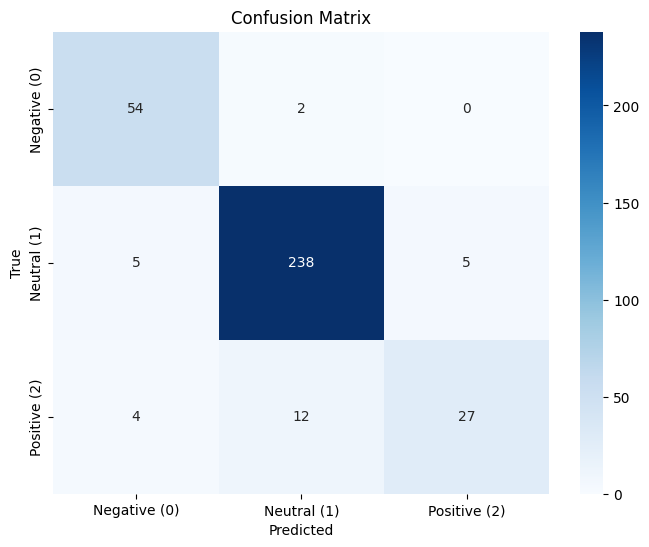

In [19]:
# --- Confusion Matrix ---
print("\n--- Final Classification Report ---")
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
target_names = ["Negative (0)", "Neutral (1)", "Positive (2)"]
print(classification_report(test_labels, y_pred, target_names=target_names))
print("---------------------------------")

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()